# 波士顿房价预测任务

波士顿房价预测是一个经典的机器学习任务，类似于程序员世界的“Hello World”。和大家对房价的普遍认知相同，波士顿地区的房价是由诸多因素影响的。该数据集统计了13种可能影响房价的因素和该类型房屋的均价，期望构建一个基于13个因素进行房价预测的模型，如 **图1** 所示。
<br></br>
<center><img src="https://ai-studio-static-online.cdn.bcebos.com/c19602ce74284e3b9a50422f8dc37c0c1c79cf5cd8424994b6a6b073dcb7c057" width="500" hegiht="" ></center>
<center><br>图1：波士顿房价影响因素示意图</br></center>
<br></br>

对于预测问题，可以根据预测输出的类型是连续的实数值，还是离散的标签，区分为回归任务和分类任务。因为房价是一个连续值，所以房价预测显然是一个回归任务。下面我们尝试用最简单的线性回归模型解决这个问题，并用神经网络来实现这个模型。

## 线性回归模型

假设房价和各影响因素之间能够用线性关系来描述：

$$y = {\sum_{j=1}^Mx_j w_j} + b$$

模型的求解即是通过数据拟合出每个$w_j$和$b$。其中，$w_j$和$b$分别表示该线性模型的权重和偏置。一维情况下，$w_j$ 和 $b$ 是直线的斜率和截距。

线性回归模型使用均方误差作为损失函数（Loss），用以衡量预测房价和真实房价的差异，公式如下：

$$MSE = \frac{1}{n} \sum_{i=1}^n(\hat{Y_i} - {Y_i})^{2}$$



五个步骤：
1、数据处理：
从本地文件或网络地址读取数据，并做预处理操作，如校验数据的正确性等。
2、模型设计：
完成网络结构的设计（模型三要素之一），相当于模型的假设空间，即模型能够表达的关系集合。
3、训练配置：
设定模型采用的寻解算法（模型三要素之二），即优化器，并指定计算资源。
4、训练过程：
循环调用训练过程，每轮均包括前向计算、损失函数（优化目标，模型三要素之三）和后向传播这三个步骤。
5、保存模型：
将训练好的模型保存，以备预测时调用。

1、数据处理：
从本地文件或网络地址读取数据，并做预处理操作，如校验数据的正确性等。

In [133]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [134]:
def load_data():
    # 从文件导入数据
    datafile = './work/housing.data'
    data = np.fromfile(datafile, sep=' ')

    # 每条数据包括14项，其中前面13项是影响因素，第14项是相应的房屋价格中位数
    feature_names = [ 'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', \
                      'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV' ]
    feature_num = len(feature_names)

    # 将原始数据进行Reshape，变成[N, 14]这样的形状
    data = data.reshape([data.shape[0] // feature_num, feature_num])

    # 将原数据集拆分成训练集和测试集
    # 这里使用80%的数据做训练，20%的数据做测试
    # 测试集和训练集必须是没有交集的
    ratio = 0.8
    offset = int(data.shape[0] * ratio)
    training_data = data[:offset]

    # 计算train数据集的最大值，最小值，平均值
    maximums, minimums, avgs = training_data.max(axis=0), training_data.min(axis=0), \
                                 training_data.sum(axis=0) / training_data.shape[0]

    # 对数据进行归一化处理
    for i in range(feature_num):
        #print(maximums[i], minimums[i], avgs[i])
        data[:, i] = (data[:, i] - avgs[i]) / (maximums[i] - minimums[i])

    # 训练集和测试集的划分比例
    training_data = data[:offset]
    test_data = data[offset:]
    return training_data, test_data

# end load_data

2、模型设计：
完成网络结构的设计（模型三要素之一），相当于模型的假设空间，即模型能够表达的关系集合。

3、训练配置：
设定模型采用的寻解算法（模型三要素之二），即优化器，并指定计算资源。

4、训练过程：
循环调用训练过程，每轮均包括前向计算、损失函数（优化目标，模型三要素之三）和后向传播这三个步骤。

In [135]:
class Network(object):
    def __init__(self, num_of_weights, lambda_reg=0.01):
        # 随机产生w的初始值
        # 为了保持程序每次运行结果的一致性，此处设置固定的随机数种子
        np.random.seed(0)
        self.w = np.random.randn(num_of_weights, 1)
        self.b = 0.
        self.lambda_reg = lambda_reg  # 正则化系数
        
    def forward(self, x):
        z = np.dot(x, self.w) + self.b
        zz = self.sigmoid(z)  # 使用ReLU作为激活函数
        return z
    
    def loss(self, z, y):
        error = z - y
        num_samples = error.shape[0]
        cost = np.mean(error * error)
        reg_term = 0.5 * self.lambda_reg * np.sum(self.w * self.w)  # 正则化惩罚项
        cost += reg_term
        return cost
    
    def gradient(self, x, y):
        z = self.forward(x)
        N = x.shape[0]
        gradient_w = (1. / N * np.dot(x.T, (z - y))) + self.lambda_reg * self.w  # 正则化项的梯度
        gradient_b = 1. / N * np.sum(z - y)
        return gradient_w, gradient_b
    
    def update(self, gradient_w, gradient_b, eta = 0.01):
        self.w = self.w - eta * gradient_w
        self.b = self.b - eta * gradient_b
            
                
    def train(self, training_data, num_epoches, batch_size=10, eta=0.01):
        n = len(training_data)
        losses = []
        for epoch_id in range(num_epoches):
            # 在每轮迭代开始之前，将训练数据的顺序随机的打乱，
            # 然后再按每次取batch_size条数据的方式取出
            np.random.shuffle(training_data)
            # 将训练数据进行拆分，每个mini_batch包含batch_size条的数据
            mini_batches = [training_data[k:k+batch_size] for k in range(0, n, batch_size)]
            for iter_id, mini_batch in enumerate(mini_batches):
                #print(self.w.shape)
                #print(self.b)
                x = mini_batch[:, :-1]
                y = mini_batch[:, -1:]
                a = self.forward(x)
                loss = self.loss(a, y)
                gradient_w, gradient_b = self.gradient(x, y)
                self.update(gradient_w, gradient_b, eta)
                losses.append(loss)
                print('Epoch {:3d} / iter {:3d}, loss = {:.4f}'.
                                 format(epoch_id, iter_id, loss))
        
        return losses

    def relu(self, x):
        return np.maximum(0, x)

    def leaky_relu(self, x, alpha=0.01):
        return np.where(x >= 0, x, alpha * x)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
# end class

In [136]:
# 获取数据
train_data, test_data = load_data()

# 创建网络
net = Network(13,0.04)
# 启动训练
losses = net.train(train_data, num_epoches=100, batch_size=101, eta=0.1)

Epoch   0 / iter   0, loss = 2.7980
Epoch   0 / iter   1, loss = 1.8643
Epoch   0 / iter   2, loss = 1.8636
Epoch   0 / iter   3, loss = 2.1236
Epoch   1 / iter   0, loss = 2.2447
Epoch   1 / iter   1, loss = 1.7614
Epoch   1 / iter   2, loss = 1.4214
Epoch   1 / iter   3, loss = 1.5521
Epoch   2 / iter   0, loss = 1.3283
Epoch   2 / iter   1, loss = 1.4283
Epoch   2 / iter   2, loss = 1.4724
Epoch   2 / iter   3, loss = 1.4709
Epoch   3 / iter   0, loss = 1.0419
Epoch   3 / iter   1, loss = 1.4031
Epoch   3 / iter   2, loss = 1.0687
Epoch   3 / iter   3, loss = 1.2063
Epoch   4 / iter   0, loss = 1.2628
Epoch   4 / iter   1, loss = 1.0029
Epoch   4 / iter   2, loss = 0.8629
Epoch   4 / iter   3, loss = 0.8353
Epoch   5 / iter   0, loss = 1.1752
Epoch   5 / iter   1, loss = 0.8070
Epoch   5 / iter   2, loss = 0.7696
Epoch   5 / iter   3, loss = 0.6236
Epoch   6 / iter   0, loss = 0.7012
Epoch   6 / iter   1, loss = 0.7130
Epoch   6 / iter   2, loss = 0.7283
Epoch   6 / iter   3, loss =

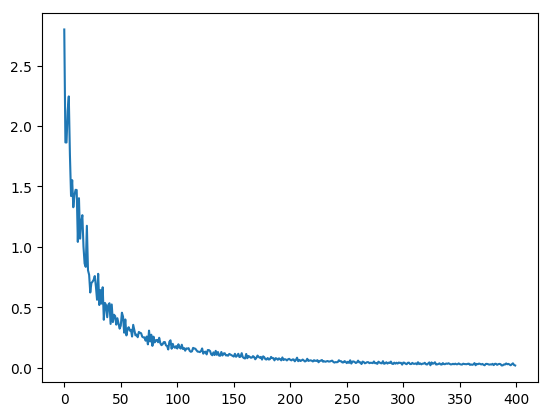

In [137]:
# 画出损失函数的变化趋势
plot_x = np.arange(len(losses))
plot_y = np.array(losses)
plt.plot(plot_x, plot_y)
plt.show()

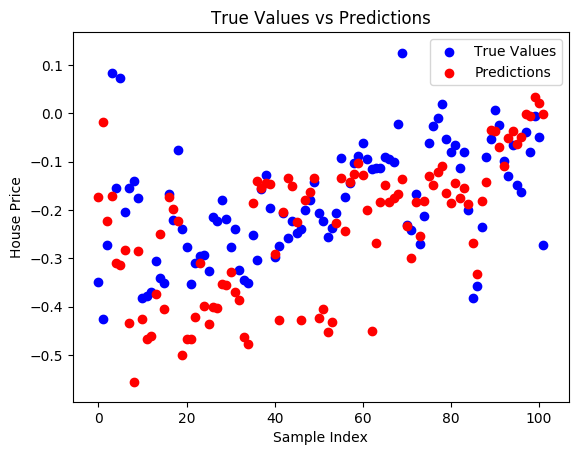

In [138]:
#####预测值与真实值的对比图：#####

# 获取测试集的预测值
x_test = test_data[:, :-1]
y_test = test_data[:, -1:]
predictions = net.forward(x_test)

# 绘制预测值与真实值的对比图
plt.scatter(range(len(y_test)), y_test, color='b', label='True Values')
plt.scatter(range(len(predictions)), predictions, color='r', label='Predictions')
plt.xlabel('Sample Index')
plt.ylabel('House Price')
plt.title('True Values vs Predictions')
plt.legend()
plt.show()

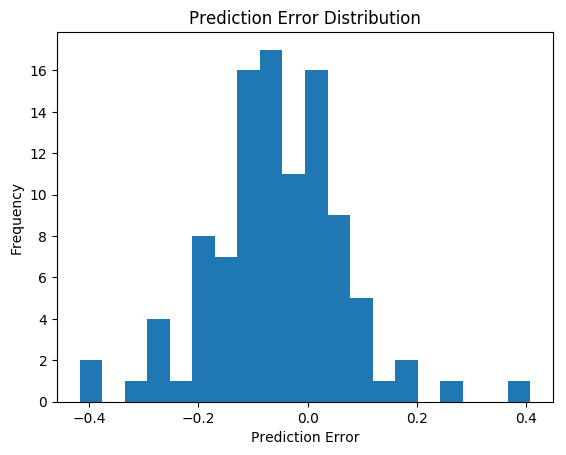

In [139]:
#####误差分布图：#####

# 计算预测值与真实值之间的误差
errors = predictions - y_test

# 绘制误差的直方图
plt.hist(errors, bins=20)
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Prediction Error Distribution')
plt.show()

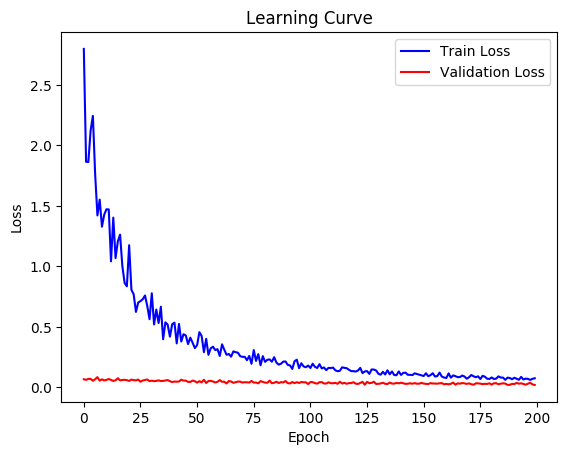

In [140]:
#####学习曲线：#####

# 获取训练误差和验证误差
train_losses = losses[:len(losses)//2]  # 前一半为训练误差
val_losses = losses[len(losses)//2:]  # 后一半为验证误差

# 绘制学习曲线
plt.plot(range(len(train_losses)), train_losses, color='b', label='Train Loss')
plt.plot(range(len(val_losses)), val_losses, color='r', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

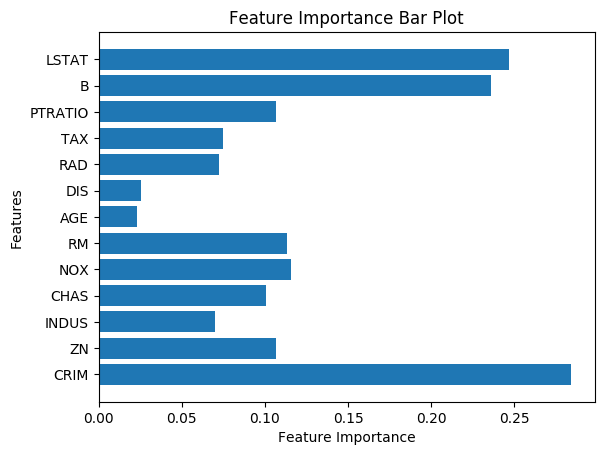

In [141]:
#####特征重要性可视化：#####

# 获取特征权重
feature_weights = np.abs(net.w.reshape(-1))  # 取绝对值以考虑权重的正负关系
feature_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE',
                 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']

# 绘制特征重要性条形图
plt.barh(range(len(feature_weights)), feature_weights, tick_label=feature_names)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance Bar Plot')
plt.show()

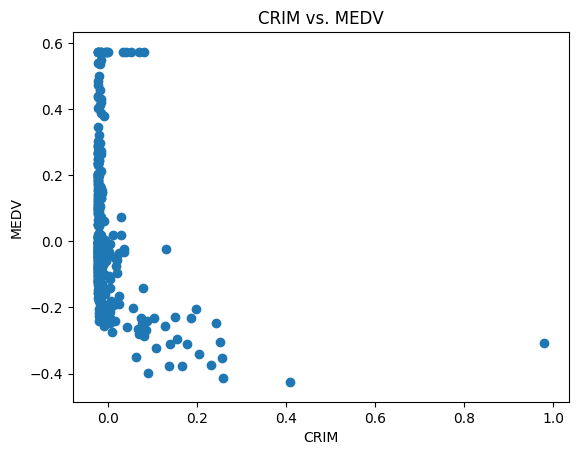

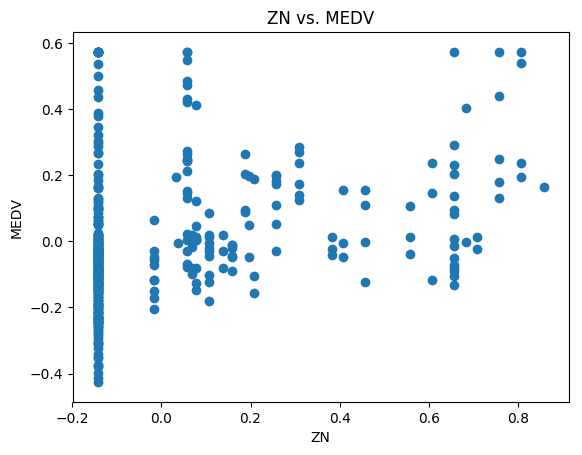

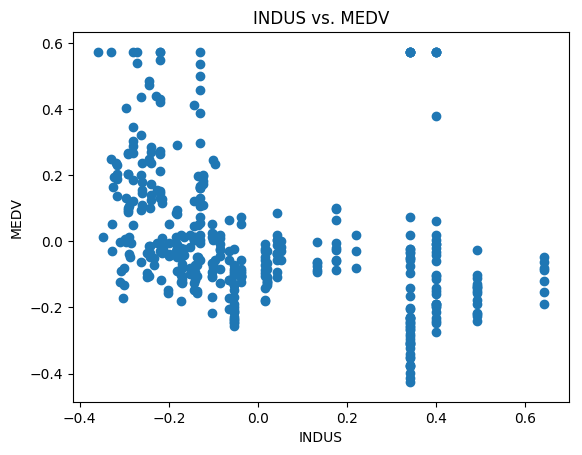

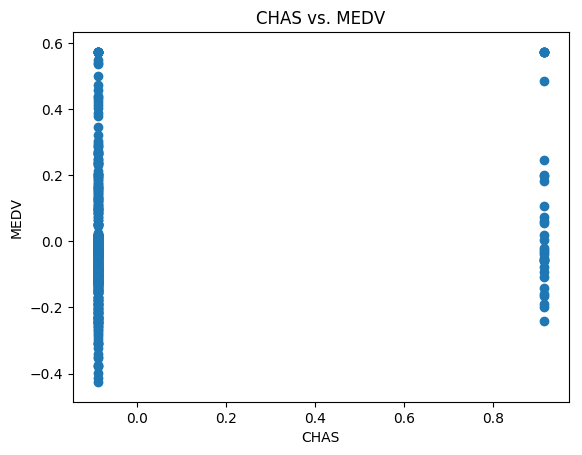

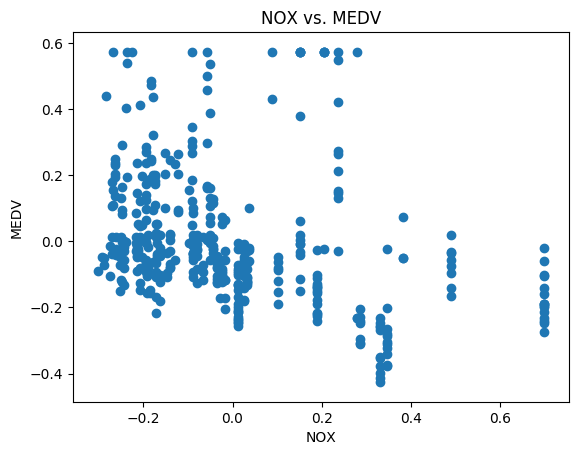

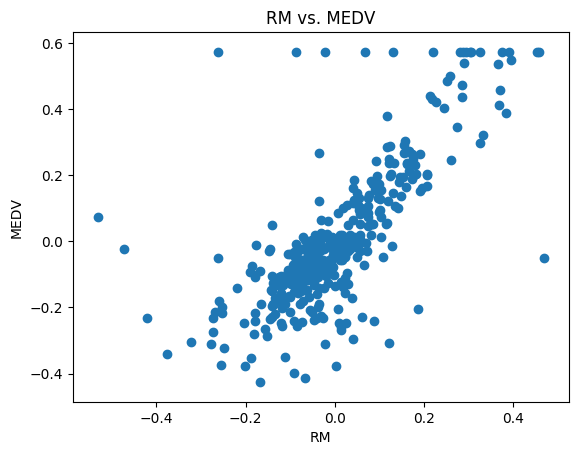

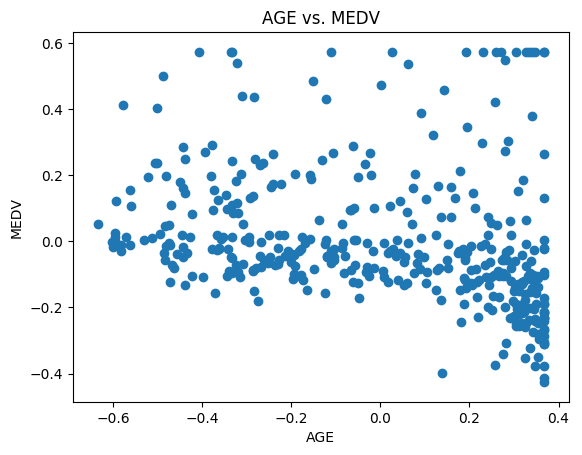

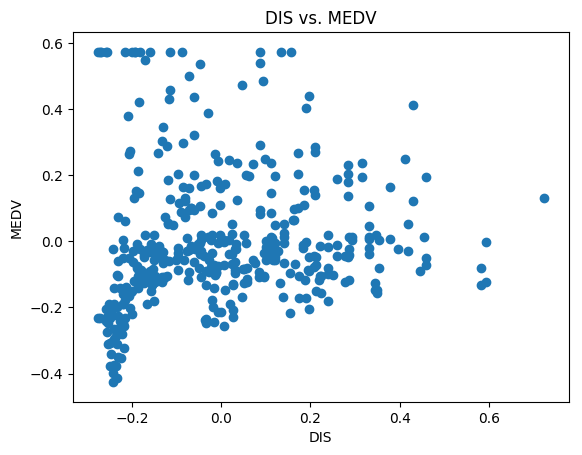

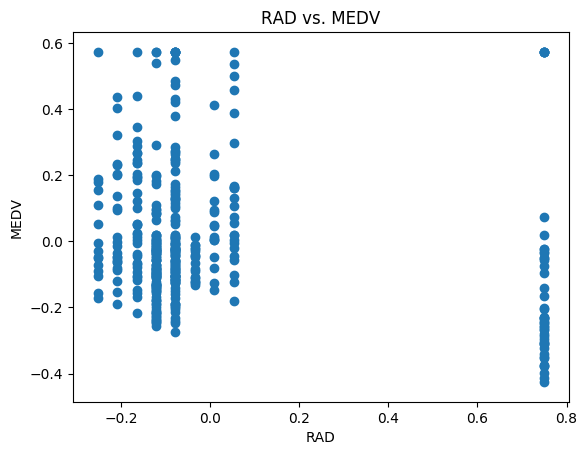

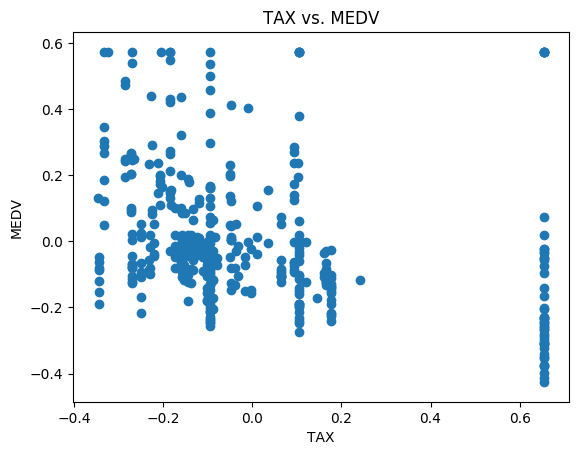

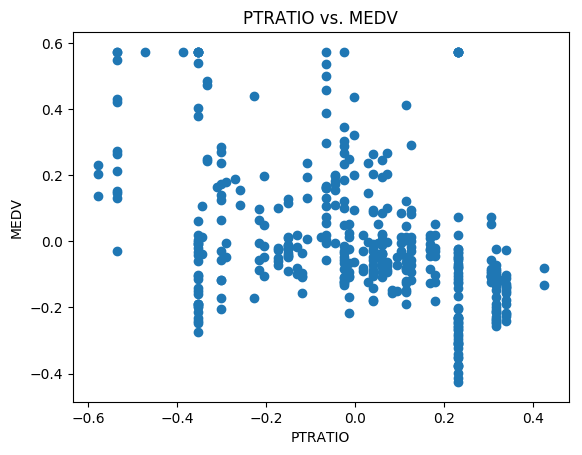

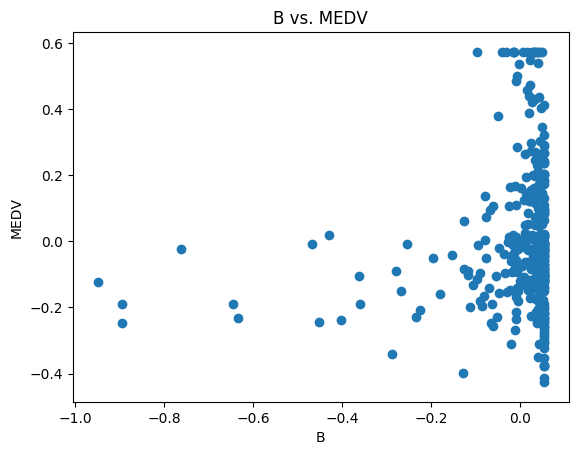

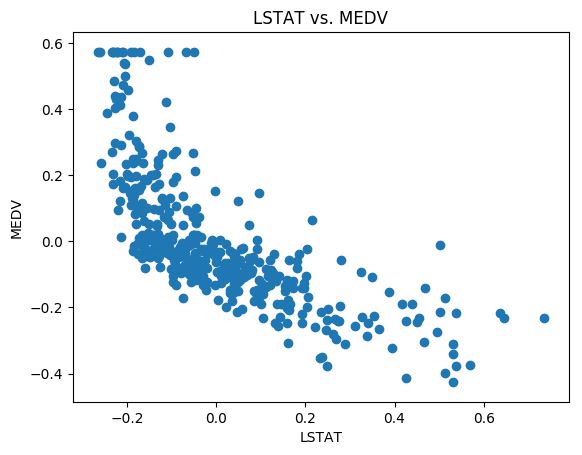

"\n# 选择一个特征和目标变量进行可视化\nfeature_index = 12  # 假设选择第一个特征 'CRIM'\nfeature_name = feature_names[feature_index]\nx = train_data[:, feature_index]\ny = train_data[:, -1:]\n\n# 绘制特征与目标变量的散点图\nplt.scatter(x, y)\nplt.xlabel(feature_name)\nplt.ylabel('MEDV')\nplt.title(f'{feature_name} vs. MEDV')\nplt.show()\n"

In [142]:
#####特征与房价的关系图：#####

for it__ in range(0,13):
    # 选择一个特征和目标变量进行可视化
    feature_index = it__  # 假设选择第一个特征 'CRIM'
    feature_name = feature_names[feature_index]
    x = train_data[:, feature_index]
    y = train_data[:, -1:]

    # 绘制特征与目标变量的散点图
    plt.scatter(x, y)
    plt.xlabel(feature_name)
    plt.ylabel('MEDV')
    plt.title(f'{feature_name} vs. MEDV')
    plt.show()

'''
# 选择一个特征和目标变量进行可视化
feature_index = 12  # 假设选择第一个特征 'CRIM'
feature_name = feature_names[feature_index]
x = train_data[:, feature_index]
y = train_data[:, -1:]

# 绘制特征与目标变量的散点图
plt.scatter(x, y)
plt.xlabel(feature_name)
plt.ylabel('MEDV')
plt.title(f'{feature_name} vs. MEDV')
plt.show()
'''

5、保存模型：
将训练好的模型保存，以备预测时调用。

结束。